In [20]:
import csv
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

#### EDA

Loading the dataset with hand labelled

In [4]:
data = pd.read_csv("comments_labelled.csv")
data = data.drop(data.columns[[0, 1]], axis=1)
data["length"] = data["body"].apply(len)
data.head()

,post_id,Created,comment_id,body,created_utc,author_id,score,link_id,parent_id,Keyword,sentiment_label,sentiment_score,sentiment,cleaned_text,mysentiment,length
0,1jo735c,2025-03-31 16:31:21,mkpjkfy,something fantastic about a fake doctor spammi...,1.743439e+09,Gom_KBull,6755,t3_1jo735c,t3_1jo735c,Medical AI,LABEL_0,0.505554,0,something fantastic fake doctor spamming b00b,0,55
1,1jo735c,2025-03-31 16:56:58,mkpomzc,https://preview.redd.it/4rh19ihv22se1.jpeg?wid...,1.743440e+09,7Hakuna_Matata7,3068,t3_1jo735c,t3_1jo735c,Medical AI,LABEL_1,0.768416,1,httpspreviewreddit4rh19ihv22se1jpegwidth1026fo...,0,118
2,1jo735c,2025-03-31 16:49:19,mkpn47r,Board certified boob doctor.,1.743440e+09,mysteriousmeatman,607,t3_1jo735c,t3_1jo735c,Medical AI,LABEL_1,0.645257,1,board certified boob doctor,0,28
3,1jo735c,2025-03-31 16:22:51,mkphvyc,This should be illegal,1.743438e+09,triple7freak1,7065,t3_1jo735c,t3_1jo735c,Medical AI,LABEL_0,0.900811,0,illegal,0,22
4,1jo735c,2025-03-31 16:35:45,mkpkfde,We’re really about to enter a grifter’s renais...,1.743439e+09,Murmido,218,t3_1jo735c,t3_1jo735c,Medical AI,LABEL_1,0.629456,1,’ really enter grifter ’ renaissance ’,0,62


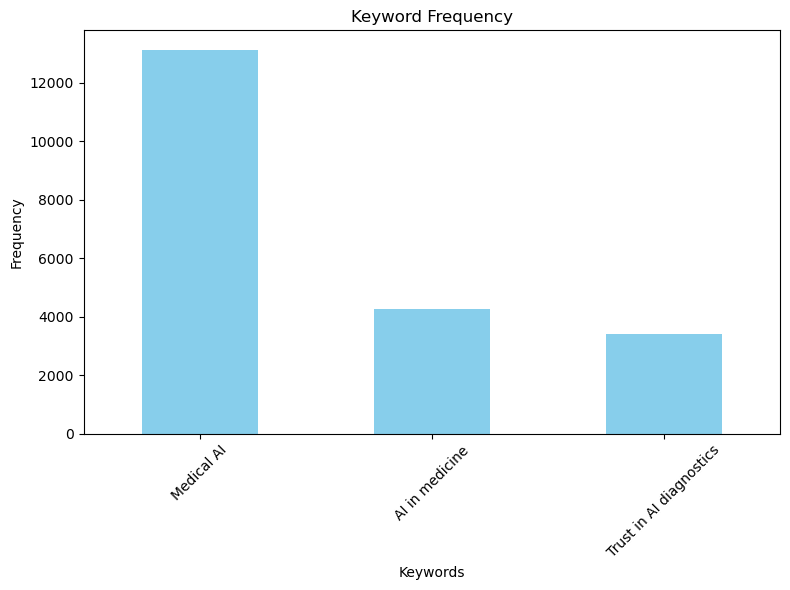

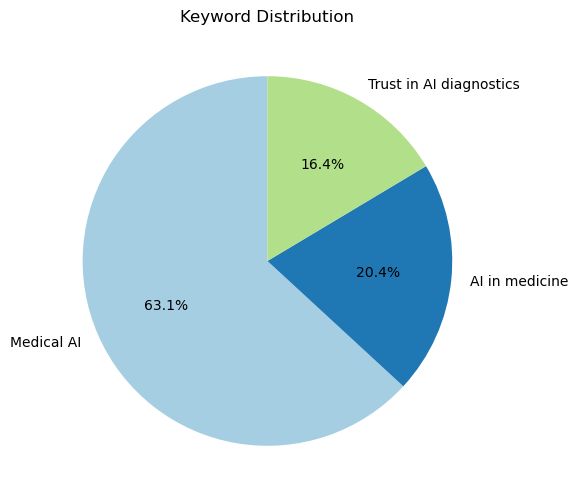

In [5]:
#Keyword counts
keyword_counts = data["Keyword"].value_counts()

# Bar chart
plt.figure(figsize=(8, 6))
keyword_counts.plot(kind='bar', color='skyblue')
plt.title('Keyword Frequency')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(6, 6))
keyword_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Keyword Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

### Analysing the comment sentiment distribution

In [8]:
def print_sentiment_stats(df, sentiment_label):
    average_length = df['length'].mean()
    median_length = df['length'].median()
    min_length = df['length'].min()
    max_length = df['length'].max()
    average_score = df['score'].mean()
    median_score = df['score'].median()
    min_score = df['score'].min()
    max_score = df['score'].max()

    print(f"\n{sentiment_label.capitalize()}:")
    print(f"Average Length: {average_length}")
    print(f"Median Length: {median_length}")
    print(f"Min Length: {min_length}")
    print(f"Max Length: {max_length}")
    print(f"Average Score: {average_score}")
    print(f"Median Score: {median_score}")
    print(f"Min Score: {min_score}")
    print(f"Max Score: {max_score}")

# Filter the DataFrame
negatives = data[data["mysentiment"] == 0]
positives = data[data["mysentiment"] == 1]  # Updated to match your sentiment mapping

# Print stats for both sentiments
print_sentiment_stats(negatives, "negatives")
print_sentiment_stats(positives, "positives")


Negatives:
Average Length: 254.88239640002686
Median Length: 131.0
Min Length: 1
Max Length: 7980
Average Score: 76.83074753173484
Median Score: 3.0
Min Score: -105
Max Score: 21662

Positives:
Average Length: 237.76977807894292
Median Length: 115.0
Min Length: 2
Max Length: 8112
Average Score: 39.18228019651025
Median Score: 3.0
Min Score: -564
Max Score: 15461


In [9]:
# Getting the posts with the most negative and positive comments 

comment_counts = data.groupby(['post_id', 'mysentiment']).size().unstack(fill_value=0)
comment_counts.columns = ['Negative', 'Positive']

# Find post IDs with the most and least positive comments
most_positive_post = comment_counts['Positive'].idxmax()
least_positive_post = comment_counts['Positive'].idxmin()

# Find post IDs with the most and least negative comments
most_negative_post = comment_counts['Negative'].idxmax()
least_negative_post = comment_counts['Negative'].idxmin()

# Display results
print(f"Post ID with most positive comments: {most_positive_post} ({comment_counts['Positive'].max()})")
print(f"Post ID with least positive comments: {least_positive_post} ({comment_counts['Positive'].min()})")
print(f"Post ID with most negative comments: {most_negative_post} ({comment_counts['Negative'].max()})")
print(f"Post ID with least negative comments: {least_negative_post} ({comment_counts['Negative'].min()})")

Post ID with most positive comments: 1heeqvo (56)
Post ID with least positive comments: 1f24pdv (0)
Post ID with most negative comments: 1he0gi6 (69)
Post ID with least negative comments: 1dise14 (0)


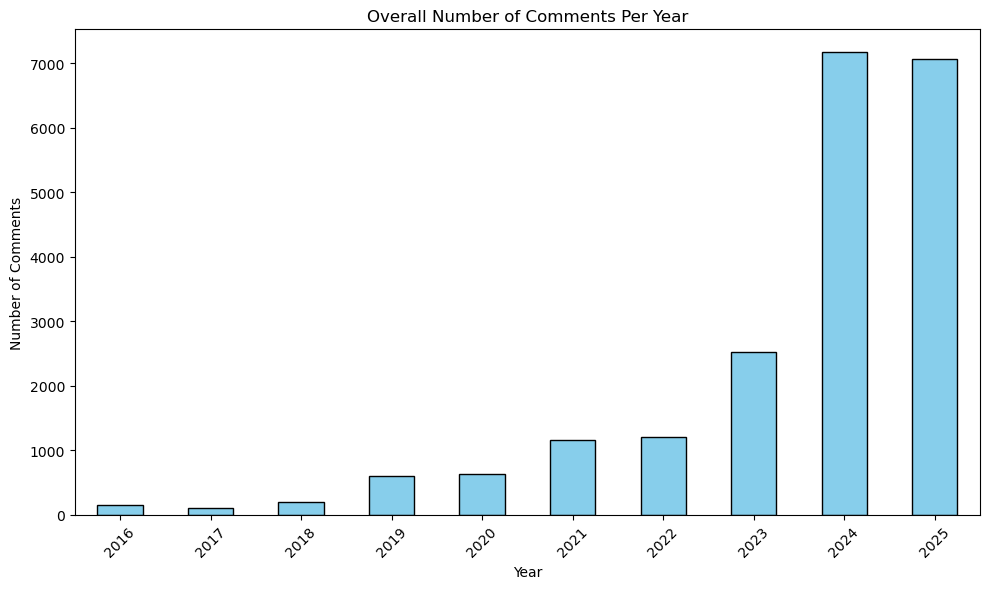

In [10]:
#Overall number of comments per year
data['Created'] = pd.to_datetime(data['Created'])

# Set 'Created' as the index for resampling
df = data.set_index('Created')

# Group by year and count the number of comments
yearly_counts = df.resample('Y').size()

# Plotting
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Overall Number of Comments Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Comments')

# Formatting the x-ticks to show only the year
plt.xticks(ticks=range(len(yearly_counts)), labels=yearly_counts.index.year, rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Analysing proportion of comments for each year
data['Created'] = pd.to_datetime(data['Created'])  # Convert to datetime
data['Year'] = data['Created'].dt.year  # Extract the year

summary = data.groupby('Year')['mysentiment'].value_counts().unstack(fill_value=0)

# Rename the columns for clarity
summary.columns = ['Negative', 'Positive']

# Calculate total counts and percentages
summary['Total'] = summary['Negative'] + summary['Positive']
summary['Negative (%)'] = (summary['Negative'] / summary['Total'] * 100).round(2)
summary['Positive (%)'] = (summary['Positive'] / summary['Total'] * 100).round(2)
summary = summary.reset_index()

# Display the final summary table
print(summary)

   Year  Negative  Positive  Total  Negative (%)  Positive (%)
0  2016       101        43    144         70.14         29.86
1  2017        67        41    108         62.04         37.96
2  2018       135        62    197         68.53         31.47
3  2019       418       188    606         68.98         31.02
4  2020       343       294    637         53.85         46.15
5  2021       709       443   1152         61.55         38.45
6  2022       804       396   1200         67.00         33.00
7  2023      1915       602   2517         76.08         23.92
8  2024      5264      1901   7165         73.47         26.53
9  2025      5133      1933   7066         72.64         27.36


### Analysing numerical features

In [12]:
#Scores
data["score"].sort_values()

13011     -564
6338      -105
13031      -91
4386       -84
6364       -83
         ...  
1155     15461
7460     16354
7476     17217
7515     19012
7479     21662
Name: score, Length: 20792, dtype: int64

In [13]:
#Correlation of numerical values
cr = data[["score", "length", "mysentiment"]].corr()
cr 

,score,length,mysentiment
score,1.000000,0.010927,-0.031357
length,0.010927,1.000000,-0.019034
mysentiment,-0.031357,-0.019034,1.000000


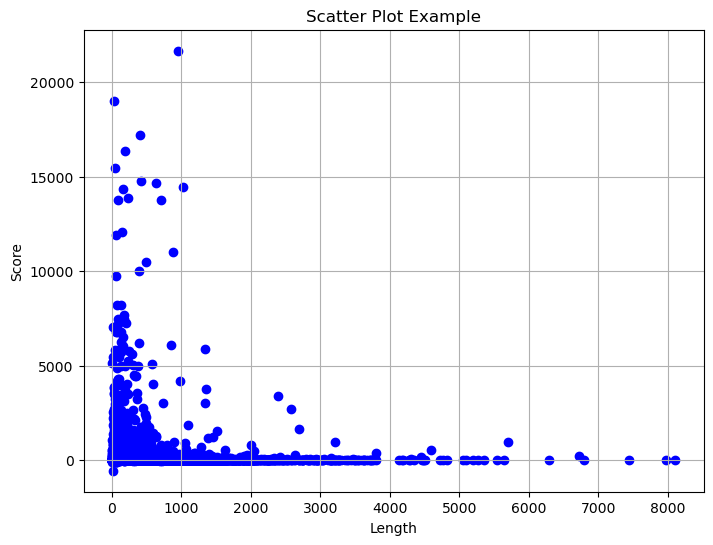

In [15]:
# Relationship of the length and the score

plt.figure(figsize=(8, 6))
plt.scatter(data['length'], data['score'], color='blue', marker='o')
plt.title('Scatter Plot Example')
plt.xlabel('Length')
plt.ylabel('Score')
plt.grid(True)
plt.show()

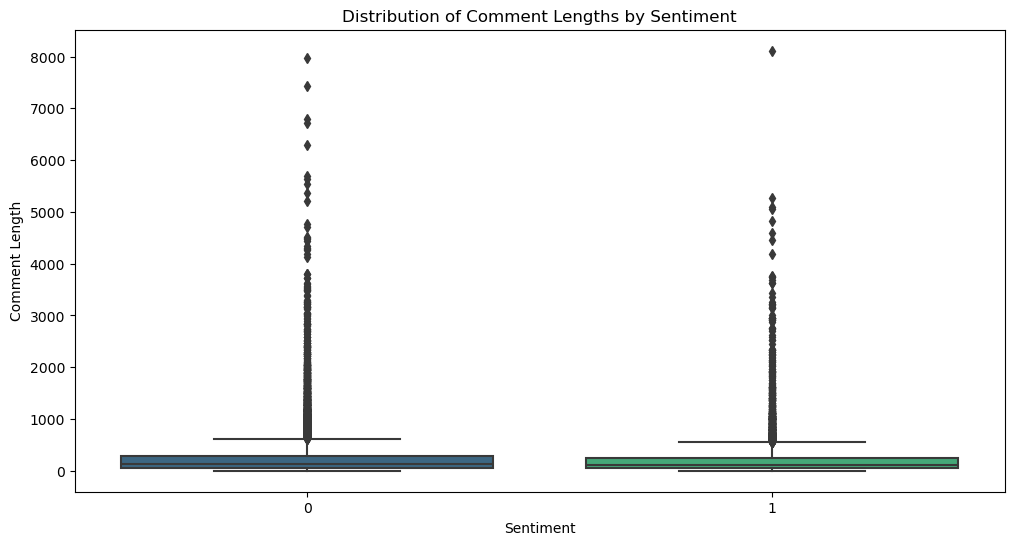

In [16]:
# Box plot of comment lengths based on sentiment

plt.figure(figsize=(12, 6))
sns.boxplot(x='mysentiment', y='length', data=data, palette='viridis')
plt.title('Distribution of Comment Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Comment Length')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


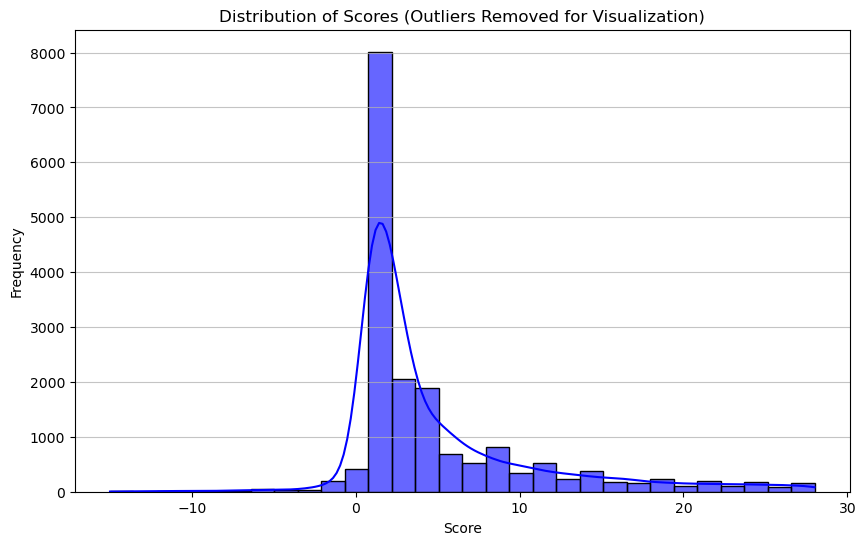

In [17]:
#Analyzing the comment score distribution

#Using IQR method to remove the outliers
# Step 1: Identify outliers
Q1 = data['score'].quantile(0.25)
Q3 = data['score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 2: Create a subset for plotting (without modifying the original DataFrame)
plot_data = data[(data['score'] >= lower_bound) & (data['score'] <= upper_bound)]

# Step 3: Visualize the cleaned data
plt.figure(figsize=(10, 6))
sns.histplot(plot_data['score'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Distribution of Scores (Outliers Removed for Visualization)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



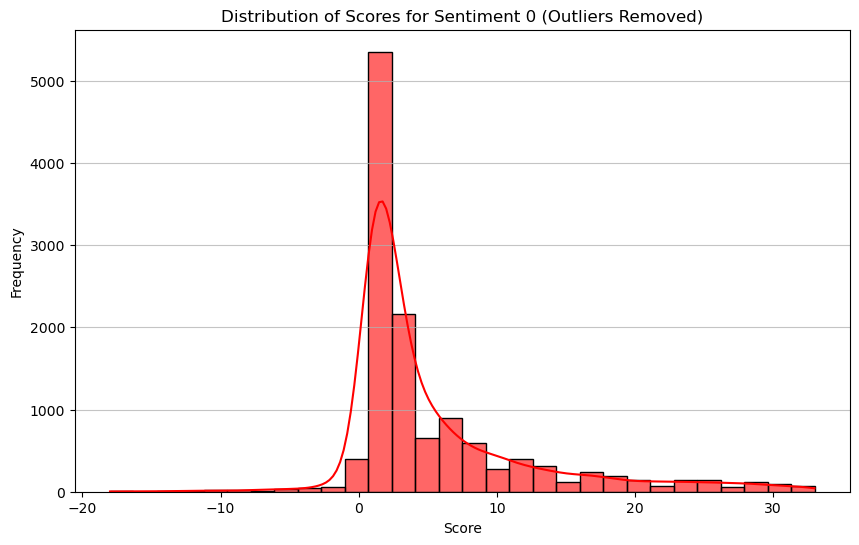

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



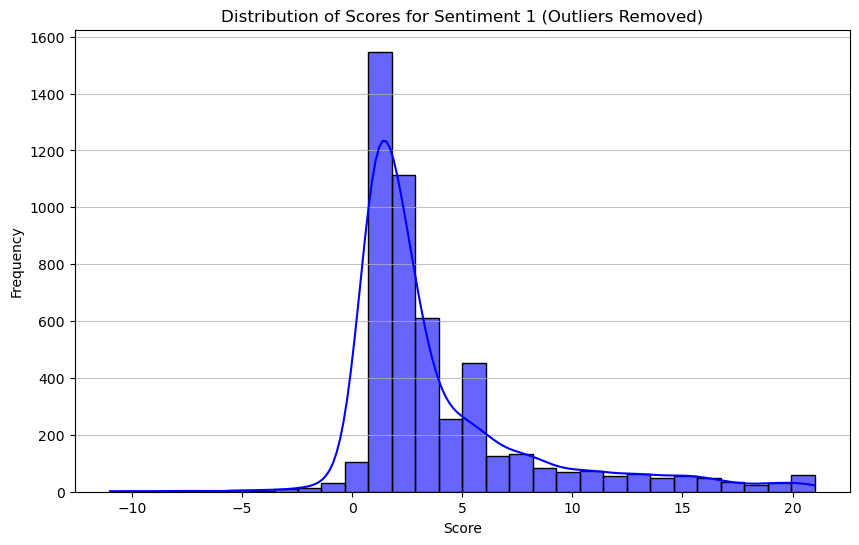

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame and 'mysentiment' column exists

# Function to plot score distribution for a given sentiment
def plot_sentiment_distribution(sentiment_value):
    # Step 1: Filter data for the specific sentiment
    sentiment_data = data[data['mysentiment'] == sentiment_value]

    # Step 2: Identify outliers using IQR method
    Q1 = sentiment_data['score'].quantile(0.25)
    Q3 = sentiment_data['score'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 3: Create a subset for plotting (without modifying the original DataFrame)
    plot_data = sentiment_data[(sentiment_data['score'] >= lower_bound) & (sentiment_data['score'] <= upper_bound)]

    # Step 4: Visualize the cleaned data
    plt.figure(figsize=(10, 6))
    sns.histplot(plot_data['score'], bins=30, kde=True, color='blue' if sentiment_value == 1 else 'red', alpha=0.6)
    plt.title(f'Distribution of Scores for Sentiment {sentiment_value} (Outliers Removed)')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot for negative sentiment (0)
plot_sentiment_distribution(0)

# Plot for positive sentiment (1)
plot_sentiment_distribution(1)

### Text analysis

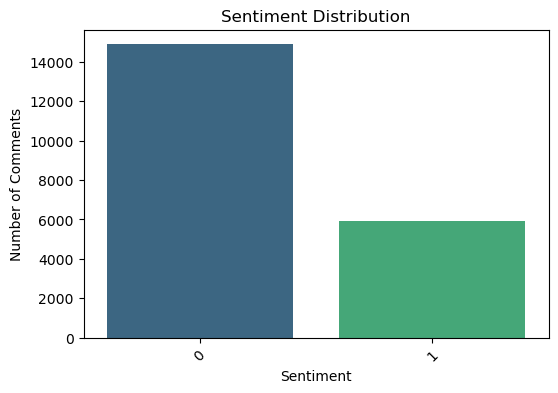

In [36]:
# Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='mysentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.show()

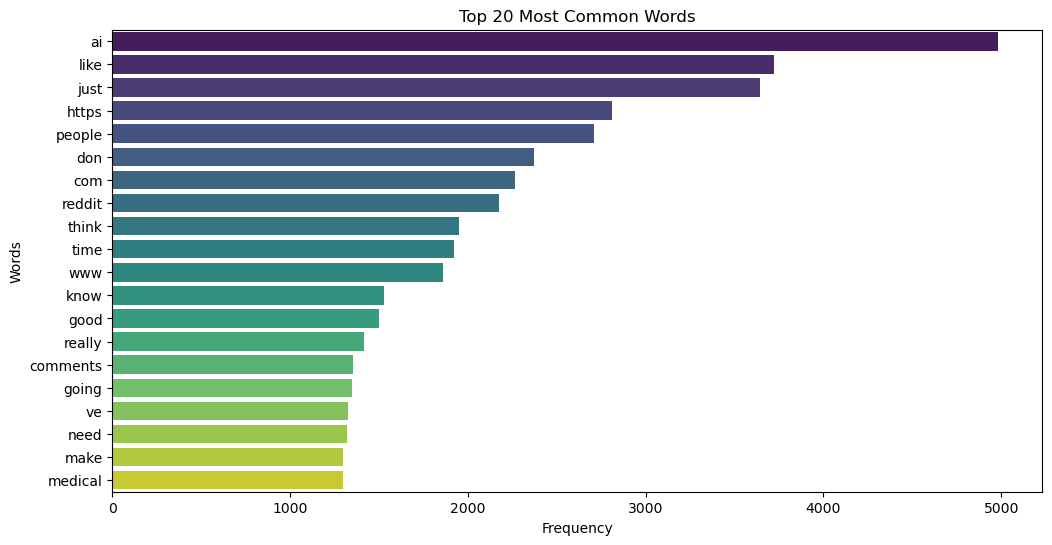

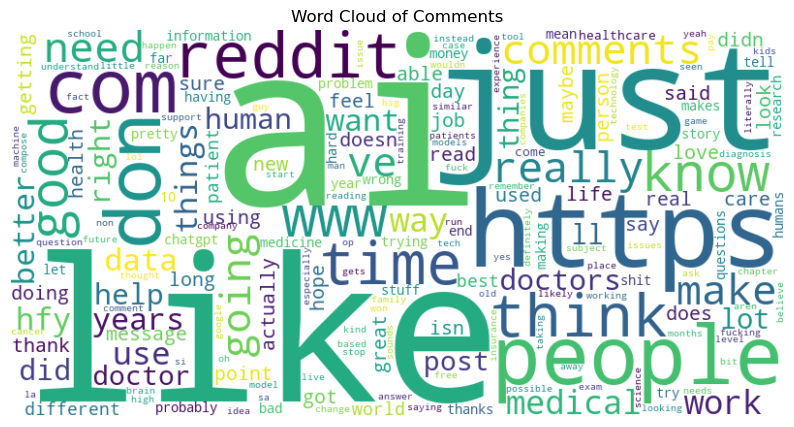

In [24]:
# Creating WordCloud

vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(data['body'])

# Sum up the counts of each vocabulary word
word_freq = word_counts.sum(axis=0)
word_freq = word_freq.A1  # Convert to a flat array

# Create a DataFrame of words and their frequencies
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})

# Sort the DataFrame by frequency
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False).head(20)

# Bar chart of the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=word_freq_df, palette='viridis')
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Word Cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words, word_freq)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

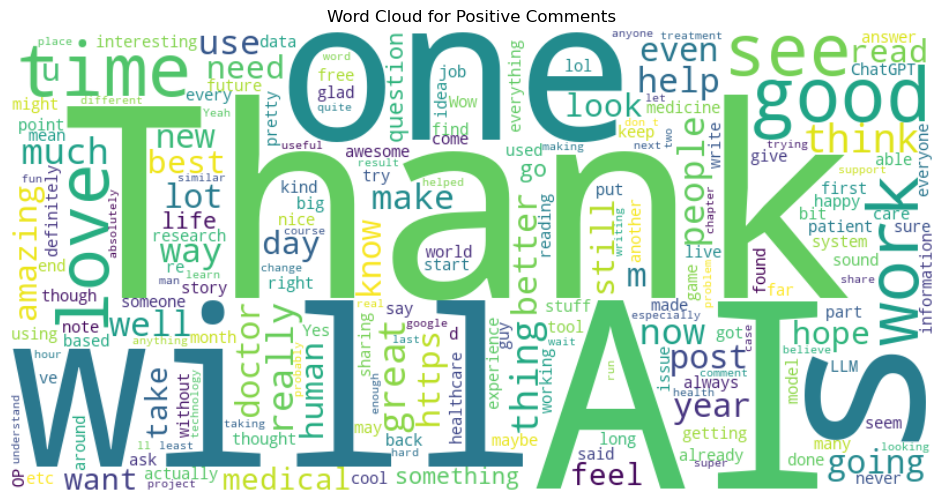

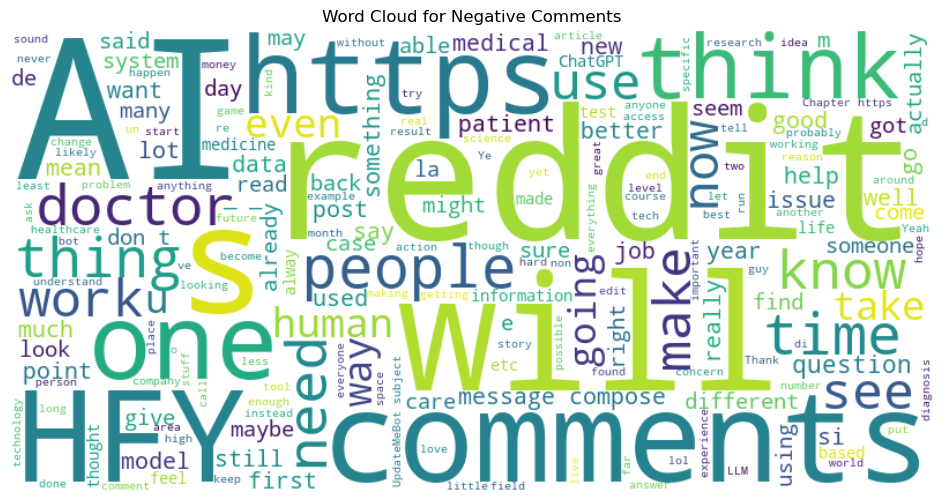

In [25]:
# Separate positive and negative comments
positive_comments = data[data['sentiment'] == 2]['body']
negative_comments = data[data['sentiment'] == 1]['body']

# Generate word cloud for positive comments
plt.figure(figsize=(12, 6))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_comments))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Comments')
plt.show()

# Generate word cloud for negative comments
plt.figure(figsize=(12, 6))
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_comments))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Comments')
plt.show()

#### Comments with Emojis 

In [32]:
def contains_emoji(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F7FF"  # Alchemical Symbols
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001F000-\U0001F02F"  # Mahjong Tiles
        "\u2600-\u26FF"          # Miscellaneous Symbols
        "\u2700-\u27BF"          # Dingbats
        "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

data['contains_emoji'] = data['body'].apply(contains_emoji)

In [33]:
# Count total comments with and without emojis
emoji_counts = data['contains_emoji'].value_counts()
total_comments = len(data)

# Calculate percentage of comments with emojis
percentage_with_emojis = (emoji_counts.get(True, 0) / total_comments) * 100
percentage_without_emojis = (emoji_counts.get(False, 0) / total_comments) * 100

# Print the results
print("Total Comments:", total_comments)
print("Comments with Emojis:", emoji_counts.get(True, 0))
print("Comments without Emojis:", emoji_counts.get(False, 0))
print(f"Percentage with Emojis: {percentage_with_emojis:.2f}%")
print(f"Percentage without Emojis: {percentage_without_emojis:.2f}%")

# Analyze sentiment distribution based on emoji presence
emoji_sentiment_counts = data.groupby(['contains_emoji', 'mysentiment']).size().unstack(fill_value=0)

# Print the sentiment distribution
print("\nSentiment Distribution Based on Emoji Presence:")
print(emoji_sentiment_counts)

# Calculate average score for comments with and without emojis
average_scores = data.groupby('contains_emoji')['score'].mean()

print("\nAverage Score Based on Emoji Presence:")
print(average_scores)

Total Comments: 20792
Comments with Emojis: 645
Comments without Emojis: 20147
Percentage with Emojis: 3.10%
Percentage without Emojis: 96.90%

Sentiment Distribution Based on Emoji Presence:
mysentiment         0     1
contains_emoji             
False           14476  5671
True              413   232

Average Score Based on Emoji Presence:
contains_emoji
False    66.703082
True     48.618605
Name: score, dtype: float64


### Sentiment change over time

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]  # Set default figure size

<Figure size 1600x800 with 0 Axes>

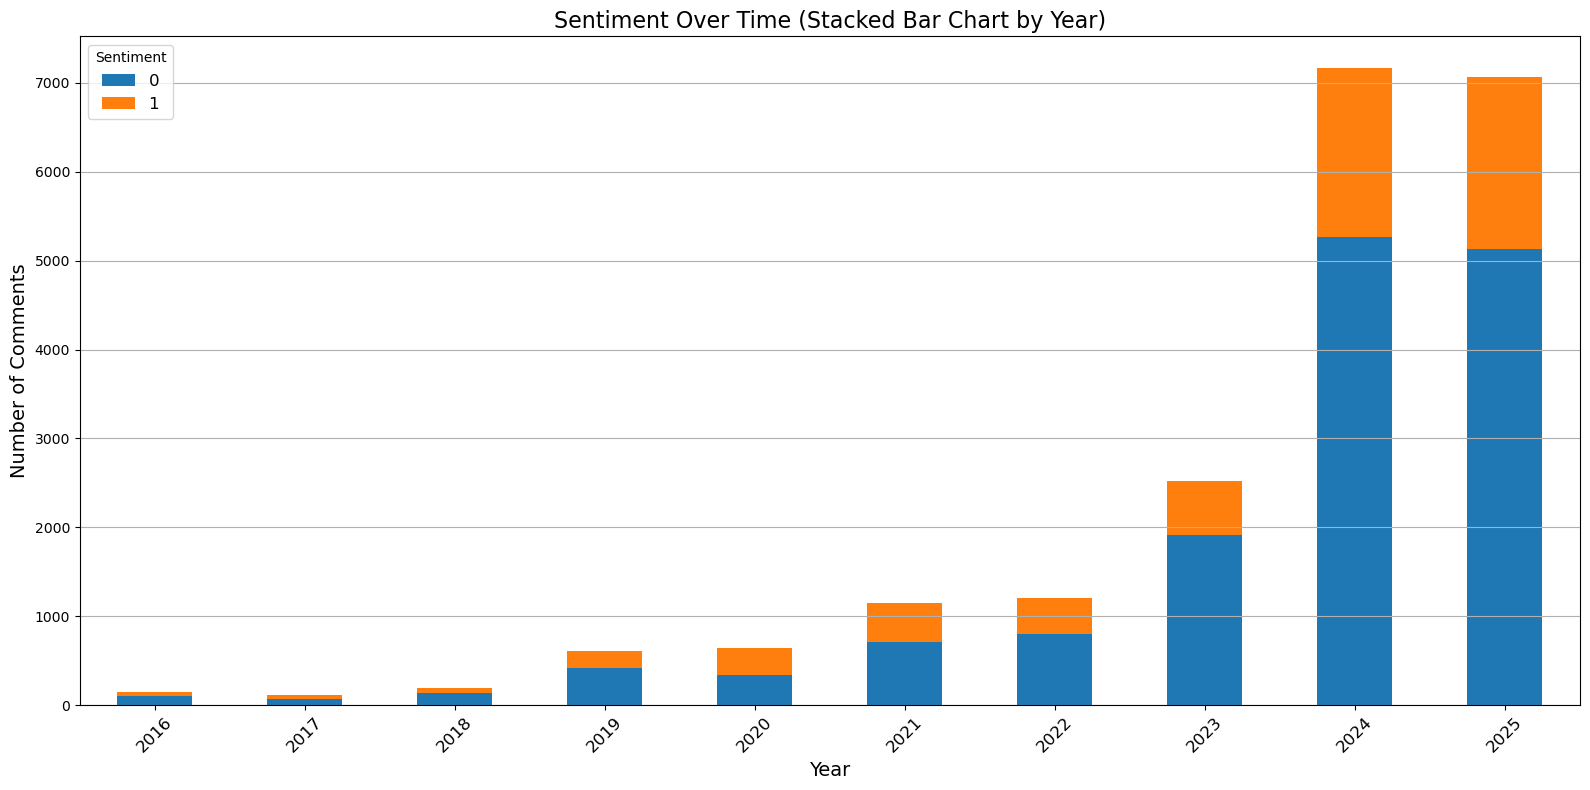

{2016: {'positive': 0, 'negative': 0}, 2017: {'positive': 0, 'negative': 0}, 2018: {'positive': 0, 'negative': 0}, 2019: {'positive': 0, 'negative': 0}, 2020: {'positive': 0, 'negative': 0}, 2021: {'positive': 0, 'negative': 0}, 2022: {'positive': 0, 'negative': 0}, 2023: {'positive': 0, 'negative': 0}, 2024: {'positive': 0, 'negative': 0}, 2025: {'positive': 0, 'negative': 0}}


In [28]:
data['Created'] = pd.to_datetime(data['Created'])

# Resample the data by year and count the sentiments
sentiment_over_year = data.resample('Y', on='Created').mysentiment.value_counts().unstack(fill_value=0)

# Plotting stacked bar chart for sentiment counts by year
plt.figure(figsize=(16, 8), dpi=100)
sentiment_over_year.plot(kind='bar', stacked=True)
plt.title('Sentiment Over Time (Stacked Bar Chart by Year)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)

# Format the x-ticks to show only the year
plt.xticks(ticks=range(len(sentiment_over_year.index)), labels=sentiment_over_year.index.year, rotation=45, fontsize=12)

plt.legend(title='Sentiment', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Create a dictionary with the number of positive and negative comments for each year
# Assuming 'positive' and 'negative' are the categories in your 'mysentiment' column
sentiment_dict = {year.year: {'positive': row.get('positive', 0), 'negative': row.get('negative', 0)}
                  for year, row in sentiment_over_year.iterrows()}

print(sentiment_dict)

<Figure size 1600x800 with 0 Axes>

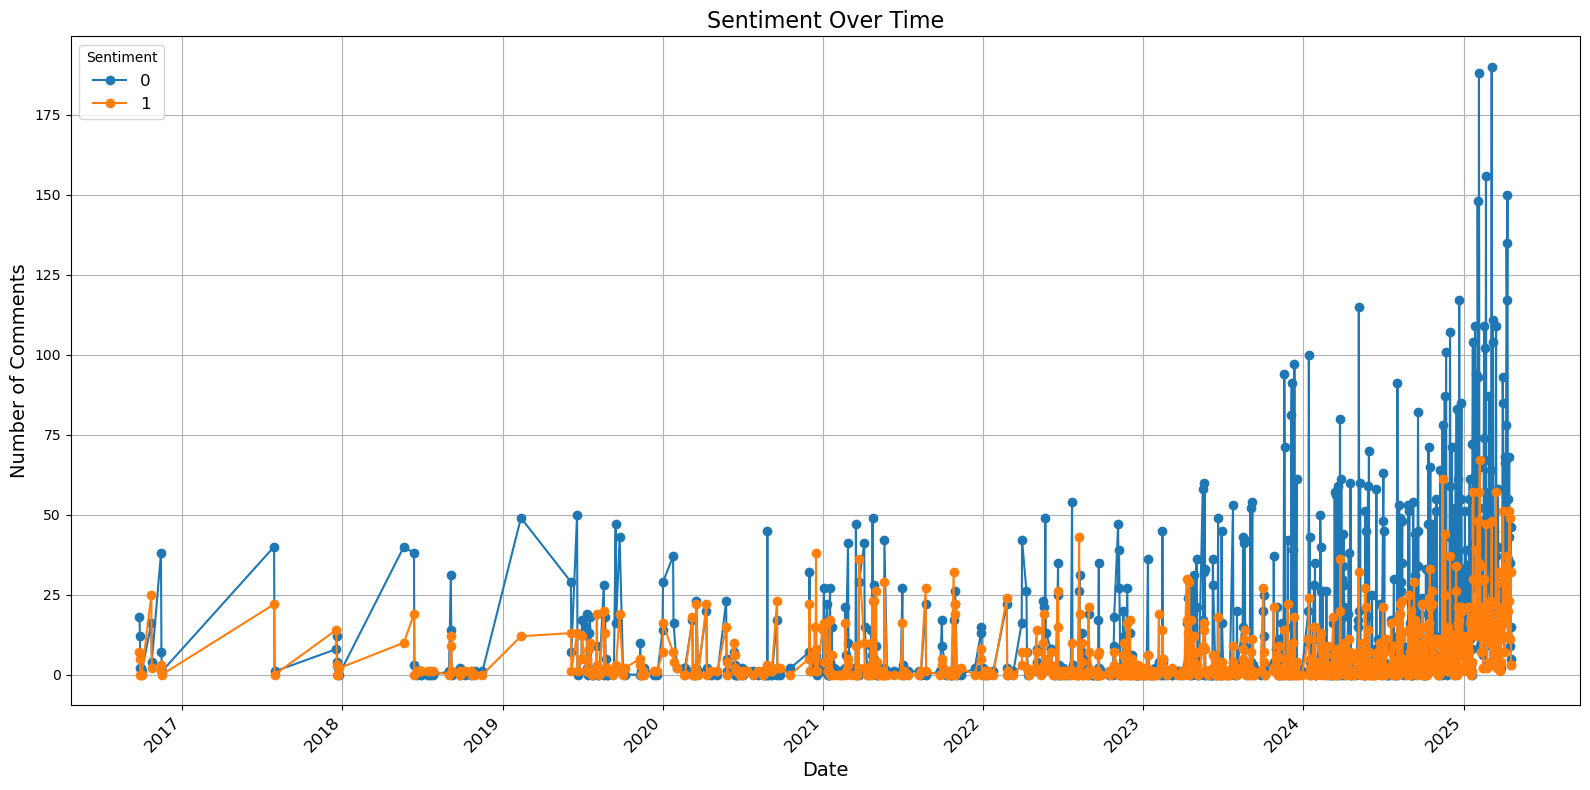

In [29]:
# Resample the data by day (you can also use 'M' for month, 'W' for week, etc.)
sentiment_over_time = data.resample('D', on='Created').mysentiment.value_counts().unstack(fill_value=0)

# Plotting sentiment over time
plt.figure(figsize=(16, 8), dpi=100)  # Increased figure size
sentiment_over_time.plot(kind='line', marker='o')
plt.title('Sentiment Over Time', fontsize=16)  # Increased title font size
plt.xlabel('Date', fontsize=14)  # Increased x-axis label font size
plt.ylabel('Number of Comments', fontsize=14)  # Increased y-axis label font size
plt.xticks(rotation=45, fontsize=12)  # Increased x-ticks font size
plt.legend(title='Sentiment', fontsize=12)  # Increased legend font size
plt.grid()
plt.tight_layout()  # Optimize layout
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


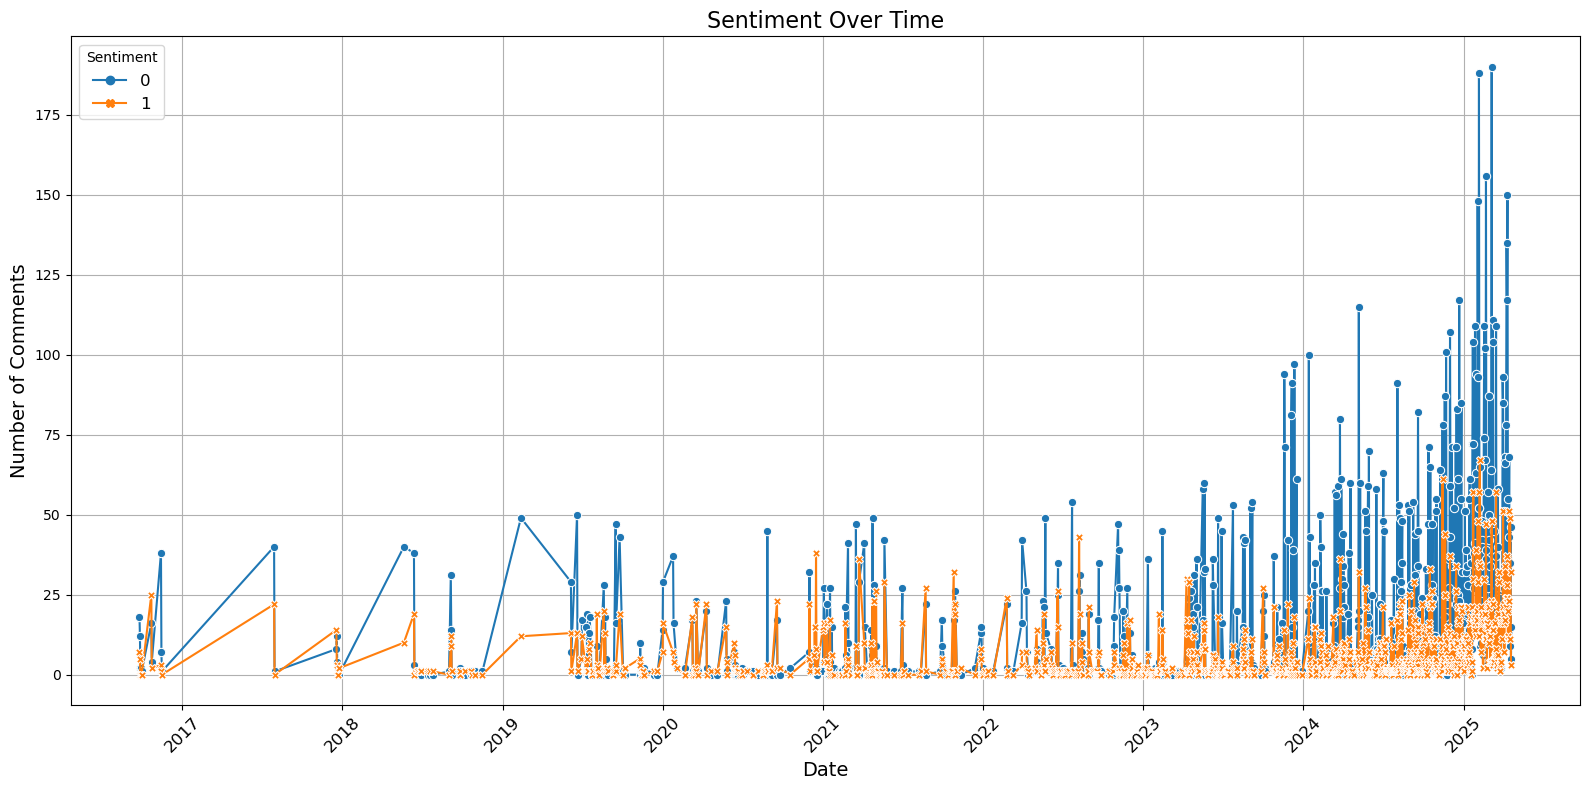

In [30]:
plt.figure(figsize=(16, 8), dpi=100)
sns.lineplot(data=sentiment_over_time, markers=True, dashes=False)
plt.title('Sentiment Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Sentiment', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

In [34]:
import plotly.express as px

# Convert sentiment_over_time to a long format for Plotly
sentiment_long = sentiment_over_time.reset_index().melt(id_vars='Created', var_name='Sentiment', value_name='Count')

fig = px.line(sentiment_long, x='Created', y='Count', color='Sentiment', title='Interactive Sentiment Over Time')
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [113]:
chart_studio.tools.set_credentials_file(username='ILYASYES', api_key='')

# Convert sentiment_over_time to a long format for Plotly
sentiment_long = sentiment_over_time.reset_index().melt(id_vars='Created', var_name='Sentiment', value_name='Count')

# Create the interactive figure
fig = px.line(sentiment_long, x='Created', y='Count', color='Sentiment', title='Interactive Sentiment Over Time')
fig.update_traces(mode='lines+markers')

# Upload the figure to Plotly Chart Studio
py.plot(fig, filename='interactive-sentiment-over-time', auto_open=True)

'https://chart-studio.plotly.com/~ILYASYES/1/'